In [5]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt

# 1. Dataset Preparation
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data() # Load CIFAR-10

# Split training data into train and validation
split_index = int(x_train.shape[0] * 0.8)
x_train, x_val = x_train[:split_index], x_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]


In [2]:

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tfl.Rescaling(1./255),
    tfl.RandomFlip("horizontal"),
    tfl.RandomRotation(0.1),
    tfl.RandomContrast(factor=(0.2, 0.9)),
    tfl.RandomZoom(height_factor=(0.1, 0.3)),
])

def preprocess(x, y):
    return data_augmentation(x), tf.one_hot(tf.squeeze(y), 10)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(preprocess).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess).batch(64)


In [3]:

# 2. Transfer Learning: Load Pre-trained Model
base_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=(32, 32, 3))

# Freeze some layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# 3. Create New Model with Pre-trained Base
model = tf.keras.Sequential([
    base_model,
    tfl.Flatten(),
    tfl.Dense(256, activation="relu"),
    tfl.Dense(128, activation="relu"),
    tfl.Dense(64, activation="relu"),
    tfl.Dense(10, activation="softmax")
])

# 4. Train the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=2)



80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 135ms/step - accuracy: 0.2916 - loss: 1.8771 - val_accuracy: 0.5096 - val_loss: 1.4084
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - accuracy: 0.5289 - loss: 1.3483 - val_accuracy: 0.5713 - val_loss: 1.2399


157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.5653 - loss: 1.2571
Loss: 1.26023268699646, Accuracy: 0.5573999881744385


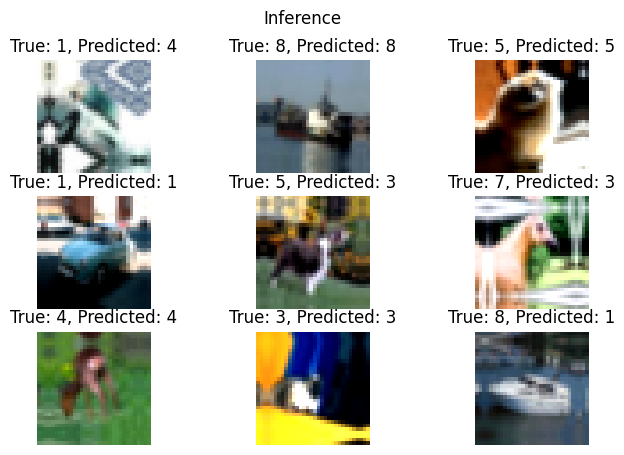

In [7]:
# 5. Evaluate
loss, accuracy = model.evaluate(test_ds)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# 6. Visualize Predictions
image, label = next(iter(val_ds))
images = image.numpy()[:9]
predictions = tf.argmax(model(image), axis=-1)
labels = tf.argmax(label, axis=-1) # Get original labels

plt.figure(figsize=(8,5))
plt.suptitle("Inference")
for i, (img, pred, true_label) in enumerate(zip(images, predictions, labels)):
    plt.subplot(3, 3, i + 1)
    plt.title(f"True: {true_label}, Predicted: {pred}")
    plt.imshow(img)
    plt.axis("off")
plt.show()